In [138]:
with open("../input/kinect-joints.txt", "r") as f:
  kinect_lines = f.readlines()

with open("../input/unity-joints.txt", "r") as f:
  unity_lines = f.readlines()

In [139]:
def parse_xy(line):
  start = line.find('x=') + 2
  mid = line.find(',', start)
  end = line.find(')', mid)
  x = int(line[start:mid].strip())
  y = int(line[line.find('y=', mid) + 2:end].strip())
  return x, y

kinect_coords = [parse_xy(line) for line in kinect_lines]
unity_coords = [parse_xy(line) for line in unity_lines]

# Sort kinect and unity coordinates by y, then x
kinect_coords = sorted(kinect_coords, key=lambda p: (p[0], p[1]))
unity_coords = sorted(unity_coords, key=lambda p: (p[0], p[1]))

print("Kinect Coordinates:")
print(kinect_coords)
print("Unity Coordinates:")
print(unity_coords)

Kinect Coordinates:
[(207, 171), (210, 160), (213, 147), (225, 115), (246, 76), (257, 270), (257, 285), (260, 214), (265, 157), (272, 60), (273, 73), (274, 109), (275, 31), (275, 158), (286, 158), (291, 211), (293, 267), (295, 283), (300, 77), (314, 117), (326, 153), (328, 177), (330, 167)]
Unity Coordinates:
[(149, 412), (153, 383), (163, 351), (198, 270), (253, 174), (278, 676), (279, 710), (288, 525), (300, 379), (320, 132), (321, 162), (324, 256), (326, 66), (328, 381), (356, 380), (369, 518), (377, 671), (380, 706), (391, 176), (428, 276), (460, 366), (465, 429), (468, 405)]


In [140]:
import numpy as np
from scipy.spatial import cKDTree  # type: ignore

def compute_rms_radius(points):
    centroid = np.mean(points, axis=0)
    return np.sqrt(np.mean(np.sum((points - centroid) ** 2, axis=1)))

def rigid_icp_2d_accum(src, dst, max_iter=50, tolerance=1e-6, verbose=True):
    src_trans = src.copy()
    errors = []
    prev_error = None

    # Initialize accumulated rotation and translation
    R_accum = np.eye(2)
    t_accum = np.zeros(2)

    for i in range(max_iter):
        tree = cKDTree(dst)
        _, indices = tree.query(src_trans)
        dst_matched = dst[indices]

        centroid_src = np.mean(src_trans, axis=0)
        centroid_dst = np.mean(dst_matched, axis=0)
        src_centered = src_trans - centroid_src
        dst_centered = dst_matched - centroid_dst

        H = src_centered.T @ dst_centered
        U, _, Vt = np.linalg.svd(H)
        R = Vt.T @ U.T
        if np.linalg.det(R) < 0:
            Vt[-1,:] *= -1
            R = Vt.T @ U.T

        t = centroid_dst - R @ centroid_src

        # Apply transform
        src_trans = (R @ src_trans.T).T + t

        # Accumulate transformation
        t_accum = R @ t_accum + t
        R_accum = R @ R_accum

        mean_error = np.mean(np.linalg.norm(src_trans - dst_matched, axis=1))
        errors.append(mean_error)
        if verbose:
            print(f"Iter {i+1}: error={mean_error:.4f}")
        if prev_error is not None and abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    return R_accum, t_accum, src_trans  # Accumulated R, t

def icp_with_prescaling(src, dst, max_iter=50, tolerance=1e-6, verbose=True):
    # Step 1: Estimate global scaling
    rms_src = compute_rms_radius(src)
    rms_dst = compute_rms_radius(dst)
    scale = rms_dst / rms_src if rms_src > 1e-8 else 1.0
    print(f"Initial scaling factor: {scale:.4f}")

    # Step 2: Scale src
    src_scaled = src * scale

    # Step 3: Rigid ICP (rotation + translation, no scaling)
    R, t, src_aligned = rigid_icp_2d_accum(src_scaled, dst, max_iter=max_iter, tolerance=tolerance, verbose=verbose)

    return scale, R, t, src_aligned

Initial scaling factor: 0.3871
Iter 1: error=53.4039
Iter 2: error=25.4277
Iter 3: error=18.9530
Iter 4: error=12.9565
Iter 5: error=2.3642
Iter 6: error=1.2570
Iter 7: error=1.2570


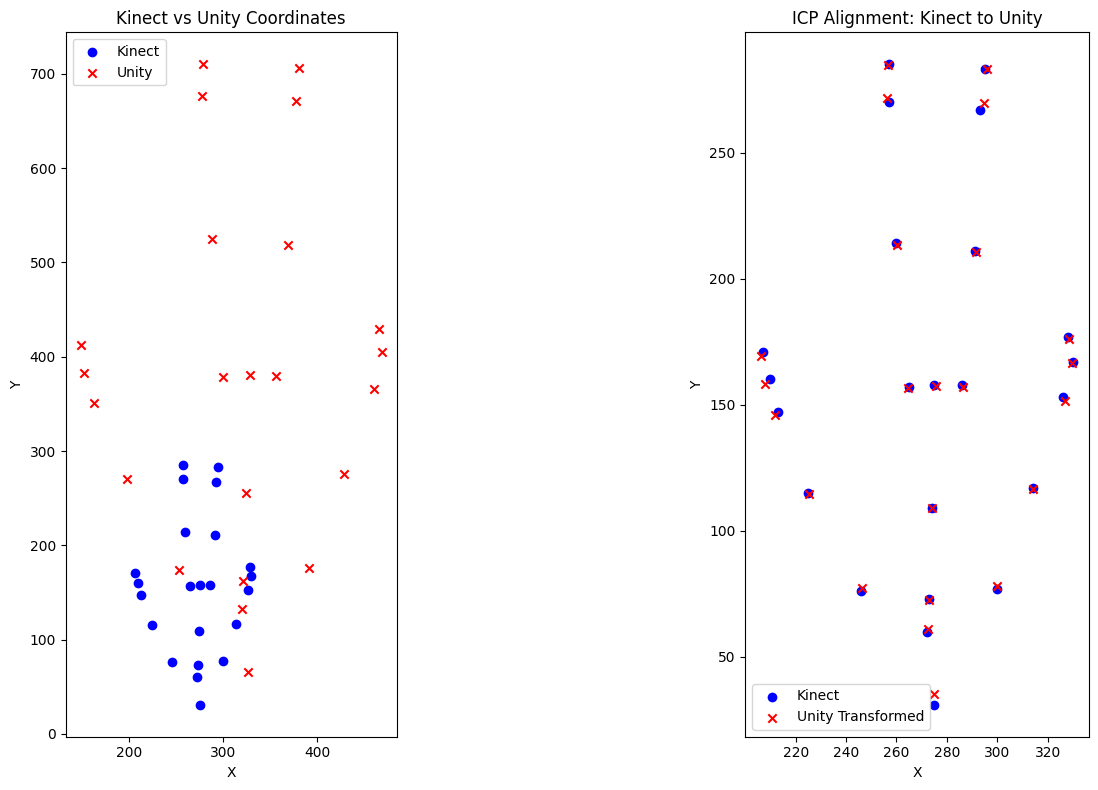

In [141]:
import matplotlib.pyplot as plt

kinect_coords = np.array(kinect_coords)
unity_coords = np.array(unity_coords)

# Perform ICP to align Kinect coordinates to Unity coordinates
scale, R, t, _  = icp_with_prescaling(unity_coords, kinect_coords)

# Apply the transformation to Unity coordinates
transformed_unity = (R @ unity_coords.T).T * scale + t

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the original coordinates
axes[0].scatter(kinect_coords[:, 0], kinect_coords[:, 1], c='blue', label='Kinect', marker='o')
axes[0].scatter(unity_coords[:, 0], unity_coords[:, 1], c='red', label='Unity', marker='x')
axes[0].legend()
axes[0].set_title('Kinect vs Unity Coordinates')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].set_aspect('equal')

# Plot the transformed Kinect coordinates
axes[1].scatter(kinect_coords[:, 0], kinect_coords[:, 1], c='blue', label='Kinect', marker='o')
axes[1].scatter(transformed_unity[:, 0], transformed_unity[:, 1], c='red', label='Unity Transformed', marker='x')
axes[1].legend()
axes[1].set_title('ICP Alignment: Kinect to Unity')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

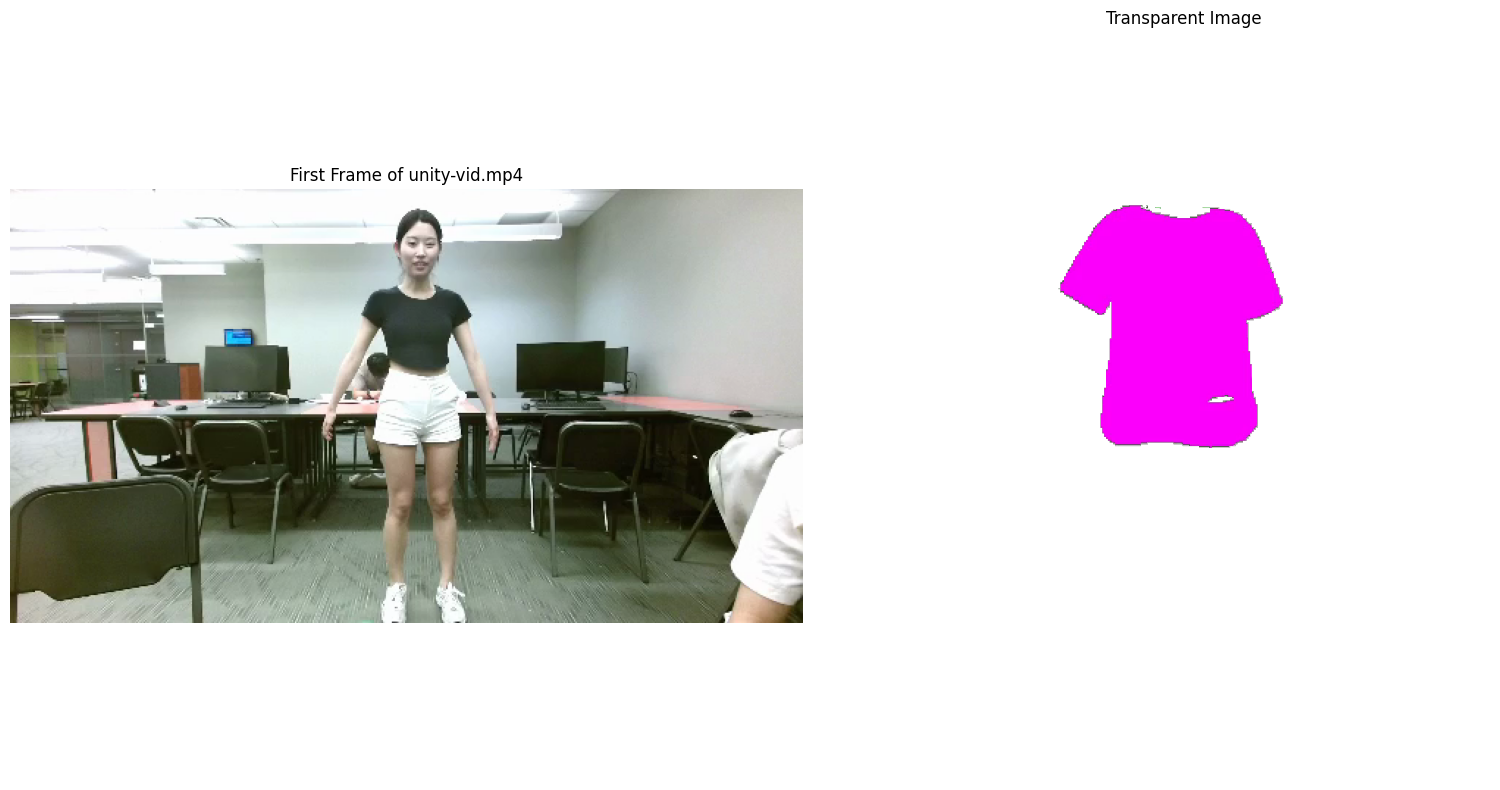

In [142]:
import cv2

# Load the video file "unity-vid.mp4"
video2 = cv2.VideoCapture("../input/live-vid.mp4")

# Read the first frame
ret2, frame2 = video2.read()
video2.release()

# Load image with alpha channel (transparency)
img_transparent = cv2.imread("../input/transparent.png", cv2.IMREAD_UNCHANGED)
img_rgba = cv2.cvtColor(img_transparent, cv2.COLOR_BGRA2RGBA) if img_transparent is not None else None
frame2_rgb = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB) if ret2 else None

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# First subplot: Show the first frame of unity-vid.mp4
if ret2:
  axes[0].imshow(frame2_rgb)
  axes[0].axis('off')
  axes[0].set_title("First Frame of unity-vid.mp4")
else:
  axes[0].text(0.5, 0.5, "Failed to read the first frame from unity-vid.mp4.", 
         ha='center', va='center', fontsize=12)
  axes[0].axis('off')
  axes[0].set_title("First Frame of unity-vid.mp4")

# Second subplot: Show the transparent image
if img_transparent is not None:
  if img_transparent.shape[2] == 4:
    axes[1].imshow(img_rgba)
    axes[1].axis('off')
    axes[1].set_title("Transparent Image")
  else:
    axes[1].text(0.5, 0.5, "Image does not have an alpha channel.",
           ha='center', va='center', fontsize=12)
    axes[1].axis('off')
    axes[1].set_title("Transparent Image")
else:
  axes[1].text(0.5, 0.5, "Failed to load transparent.png.", 
         ha='center', va='center', fontsize=12)
  axes[1].axis('off')
  axes[1].set_title("Transparent Image")

plt.tight_layout()
plt.show()

(296, 540, 4) (296, 540, 4)


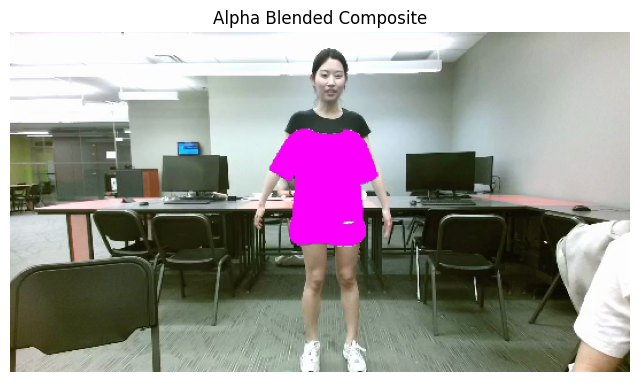

In [143]:
if img_rgba is not None and frame2 is not None:
    # Ensure both images are RGBA for blending
    if frame2.shape[2] == 3:
        frame2_rgba = np.concatenate(
            [cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB), 
             np.full(frame2.shape[:2] + (1,), 255, dtype=np.uint8)],
            axis=2
        )
    elif frame2.shape[2] == 4:
        frame2_rgba = cv2.cvtColor(frame2, cv2.COLOR_BGRA2RGBA)
    else:
        raise ValueError("frame2 must have 3 or 4 channels")

    # Compose the transformation: s * R * x + t
    M = scale * R
    affine_matrix = np.hstack([M, t.reshape(2, 1)])
    h, w = frame2_rgba.shape[:2]
    fore_aligned = cv2.warpAffine(img_rgba, affine_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0,0))

    def alpha_blend(bg, fg):
        """
        Alpha blend fg (foreground) over bg (background).
        Both must be (H, W, 4) uint8 RGBA.
        """
        bg = bg.astype(float) / 255.0
        fg = fg.astype(float) / 255.0
        out_alpha = fg[..., 3] + bg[..., 3] * (1 - fg[..., 3])
        mask = out_alpha > 0
        out_rgb = np.zeros_like(fg[..., :3])
        out_rgb[mask] = (fg[..., :3] * fg[..., 3:4] + bg[..., :3] * bg[..., 3:4] * (1 - fg[..., 3:4]))[mask] / out_alpha[mask, None]
        out = np.zeros_like(fg)
        out[..., :3] = out_rgb
        out[..., 3] = out_alpha
        return (out * 255).astype(np.uint8)

    print(frame2_rgba.shape, fore_aligned.shape)  # Should both be (H, W, 4)
    composite = alpha_blend(frame2_rgba, fore_aligned)

    # Show the composite result
    plt.figure(figsize=(8,8))
    plt.imshow(composite)
    plt.axis('off')
    plt.title("Alpha Blended Composite")
    plt.show()
else:
    print("Error: One of the images was not loaded or does not have the required shape.")

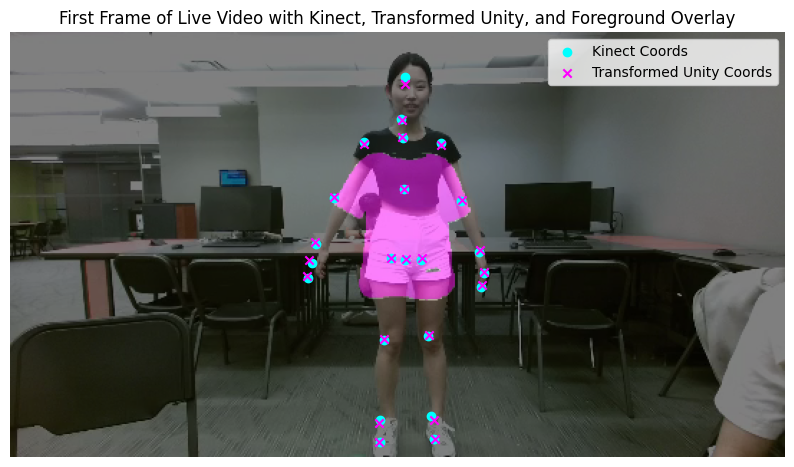

In [144]:
plt.figure(figsize=(10, 8))
plt.imshow(frame2_rgb)
plt.scatter(kinect_coords[:, 0], kinect_coords[:, 1], c='cyan', marker='o', label='Kinect Coords')
plt.scatter(transformed_unity[:, 0], transformed_unity[:, 1], c='magenta', marker='x', label='Transformed Unity Coords')
if fore_aligned is not None:
  plt.imshow(fore_aligned[..., :3], alpha=0.5)
plt.title("First Frame of Live Video with Kinect, Transformed Unity, and Foreground Overlay")
plt.axis('off')
plt.legend()
plt.show()